In [1]:
import hopsworks as hw
import pandas as pd

from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt


/Users/jayeshvasudeva/miniconda3/envs/scalable_ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project = hw.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) jayeshv
	 (2) id2223_enric

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/224405
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
wine_fg = fs.get_feature_group(name='wine', version=4)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name='wine',
                                              version=4,
                                              description="Reading from Wine Dataset",
                                              labels=['quality'],
                                              query=query)

In [4]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.11s) 


In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4245, 5), (4245, 1), (1062, 5), (1062, 1))

In [5]:
import xgboost as xgb

In [6]:
# model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# model.fit(X_train, y_train)

In [7]:
model = xgb.XGBClassifier(objective='binary:logistic')

In [8]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [9]:
y_pred = model.predict(X_test)

In [11]:
mse = mean_squared_error(y_test, y_pred)

In [12]:
mse

0.17796610169491525

In [13]:
import pandas as pd

df = pd.DataFrame({"pred": y_pred.round().astype(int),
                   "gt": y_test.squeeze()})

In [14]:
df['pred'].value_counts()

pred
0    903
1    159
Name: count, dtype: int64

In [15]:
df['gt'].value_counts()

gt
0    870
1    192
Name: count, dtype: int64

In [16]:
metrics = classification_report(df['pred'], df['gt'], output_dict=True)
metrics

{'0': {'precision': 0.9103448275862069,
  'recall': 0.8770764119601329,
  'f1-score': 0.8934010152284264,
  'support': 903.0},
 '1': {'precision': 0.421875,
  'recall': 0.5094339622641509,
  'f1-score': 0.4615384615384615,
  'support': 159.0},
 'accuracy': 0.8220338983050848,
 'macro avg': {'precision': 0.6661099137931035,
  'recall': 0.693255187112142,
  'f1-score': 0.6774697383834439,
  'support': 1062.0},
 'weighted avg': {'precision': 0.8372123392752776,
  'recall': 0.8220338983050848,
  'f1-score': 0.8287436272465954,
  'support': 1062.0}}

In [17]:
results = confusion_matrix(y_pred.round(), y_test)
df_cm = pd.DataFrame(results, [f'True {i}' for i in range(2)],
                     [f'Pred {i}' for i in range(2)])

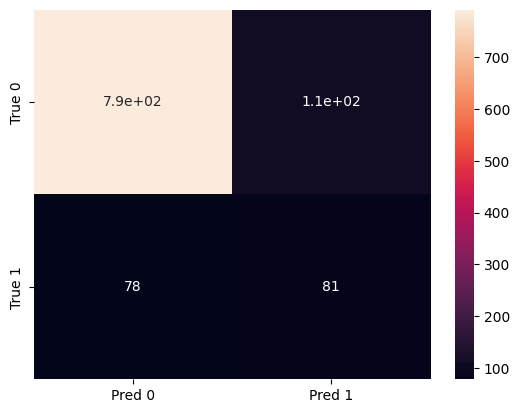

In [18]:
import seaborn as sns
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [19]:
mr = project.get_model_registry()
model_dir = "wine_model"

import joblib

joblib.dump(model, model_dir+'/wine_model.pkl')
fig.savefig(model_dir+'/confusion_matrix.png')

from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

wine_model = mr.python.create_model(
    name="wine_model",
    version=2,
    metrics={"accuracy": metrics['accuracy']},
    model_schema=model_schema,
    description="Wine model trained ; mark-I"
)
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 14983/14983 elapsed<00:01 remaining<00:002,  2.04it/s]
Uploading: 100.000%|██████████| 264893/264893 elapsed<00:02 remaining<00:00  2.04it/s]
Uploading: 100.000%|██████████| 613/613 elapsed<00:01 remaining<00:00<00:10,  2.75s/it]
Model export complete: 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/224405/models/wine_model/2


Model(name: 'wine_model', version: 2)